<a href="https://colab.research.google.com/github/YanghuiWu/MV-Hat/blob/main/transfer_vgg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/My Drive/Colab Notebooks/Hats/FinalData/
%ls

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/Colab Notebooks/Hats/FinalData
Data_Full/     HumanOnly/          ReadMe.txt              vgg16_human_only.pt
Data_Full.csv  HumanOnly.csv       vgg16_hats_imagenet.pt
HatsOnly/      lenet_hats.pt       vgg16_hats_only.pt
HatsOnly.csv   pytorch_dataset.py  vgg16_hats.pt


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import ssl
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm.notebook import tqdm
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
#from pytorch_dataset import HatsDataset
import torch.optim as optim

# for pretrained model
import torchvision.models as models

In [3]:
# for data prep
import os
import pandas as pd
from torch.utils.data import Dataset
from skimage import io
import pickle

In [4]:
class HatsDataset(Dataset):
    def __init__(self, csv_file, root_dir,transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.annotations)

    def __getitem__(self,index):
        img_path = os.path.join(self.root_dir,self.annotations.iloc[index,0])
        image = io.imread(img_path)
        y_label = torch.tensor(int(self.annotations.iloc[index,1]))

        if self.transform:
            image = self.transform(image)
        return (image,y_label)

In [5]:
in_channel = 3
num_class = 15
learning_rate = 1e-4
batch_size = 16
num_epochs = 50

checkpoint = "vgg16_hats_imagenet.pt"

# Prepare Dataset
# for transfer learning, images are resized to 224*224

tf = transforms.Compose([transforms.ToPILImage(),transforms.Resize((224, 224)),transforms.ToTensor()])

# tf = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.RandomHorizontalFlip(),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.1),
#     transforms.RandomAffine(degrees=40, translate=None, scale=(1, 2), shear=15, resample=False, fillcolor=0),
#     transforms.ToTensor(),
#     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
# ])

dataset = HatsDataset(csv_file='Data_Full.csv', root_dir='Data_Full',
                      transform = tf)  #8778

# transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

trainset, testset = torch.utils.data.random_split(dataset, [7000, len(dataset) - 7000])

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('baseballcap', 'BikeHelmet', 'BucketHat', 'CowboyHat',
           'FeltHat', 'FireFighterHat', 'FlatCap', 'GraduationCap', 'Heaterhat', 'MilitaryHelmet',
           'MotorCycle Helmet', 'Police Hat', 'SateftyHelmet', 'TopHat', 'beanie')


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# https://www.analyticsvidhya.com/blog/2021/06/transfer-learning-using-vgg16-in-pytorch/

model = models.vgg16(pretrained=True)
dropout = 0.5
num_classes = 15

model.classifier = nn.Sequential(
    nn.Linear(512 * 7 * 7, 4096),
    nn.ReLU(True),
    nn.Dropout(p=dropout),
    nn.Linear(4096, 4096),
    nn.ReLU(True),
    nn.Dropout(p=dropout),
    nn.Linear(4096, num_classes),
)

model = model.to(device=device)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

In [7]:
device

device(type='cuda')

In [8]:
losses = []
for epoch in range(num_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    for data in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        inputs = inputs.to(device=device)
        labels = labels.to(device=device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)    
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    # print loss every epoch
    print(f'[{epoch + 1} loss: {running_loss / len(trainloader)}')
    losses.append(running_loss)
    running_loss = 0.0

print('Finished Training')

[1 loss: 2.6732705330739828
[2 loss: 2.587403633278799
[3 loss: 2.495727558114213
[4 loss: 2.391095549820765
[5 loss: 2.2440826326744743
[6 loss: 2.0233199942057536
[7 loss: 1.7277569276829288
[8 loss: 1.4975337320811128
[9 loss: 1.3109584000284813
[10 loss: 1.1608211872376264
[11 loss: 1.0675675324653382
[12 loss: 0.969596727049514
[13 loss: 0.8950308771574333
[14 loss: 0.8300739182456988
[15 loss: 0.7734722396418384
[16 loss: 0.7304110570925556
[17 loss: 0.6712991587783648
[18 loss: 0.6247027377559714
[19 loss: 0.5903809758830288
[20 loss: 0.552115813782226
[21 loss: 0.5306686353210581
[22 loss: 0.5031291313605494
[23 loss: 0.4637851721296708
[24 loss: 0.4463812775705775
[25 loss: 0.4168176185594846
[26 loss: 0.39305684313212086
[27 loss: 0.36639040284981467
[28 loss: 0.33802826240760825
[29 loss: 0.3149168163146739
[30 loss: 0.30805864020518653
[31 loss: 0.28420979481989933
[32 loss: 0.2667894264466244
[33 loss: 0.24836848559257782
[34 loss: 0.24064993233840964
[35 loss: 0.227133707

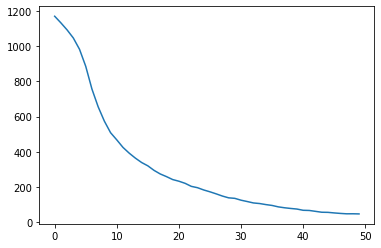

In [9]:
torch.save(model.state_dict(), checkpoint)
plt.plot(losses)

In [10]:
correct = 0
total = 0

# reinitialize the model because the evaluation does not need dropout
model.eval()
# YOUR CODE HERE
# raise NotImplementedError()
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # images = images.to('cpu')
        # labels = labels.to('cpu')
        images = images.to(device = device)
        labels = labels.to(device = device)
        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print(f'Accuracy of the model on the validation images: {100 * correct // total} %')

Accuracy of the model on the validation images: 83 %
